In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib import patches
import seaborn as sns
%matplotlib notebook

In [ ]:
from objective_function import *
from optimiser import *

In [489]:
class adam(optimizer):
    def __init__(self):
        self.alpha = 0.01
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.epsilon = 1e-8
        self.max_iter = 10000
        self.tol = 1e-2
        
    def set_parameters(self, paras):
        self.x0 = paras['x0']
        self.alpha = paras['alpha']
        self.beta_1 = paras['beta_1']
        self.beta_2 = paras['beta_2']
        self.epsilon = paras['epsilon']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
        
    def optimise(self, obj):
        m_t = 0 
        v_t = 0 
        t = 0
        x = self.x0
        while t < self.max_iter:					#till it gets converged
            t+=1
            g_t = obj.dfunc(x)		#computes the gradient of the stochastic function
            m_t = self.beta_1*m_t + (1-self.beta_1)*g_t	#updates the moving averages of the gradient
            v_t = self.beta_2*v_t + (1-self.beta_2)*(g_t*g_t)	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(self.beta_1**t))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(self.beta_2**t))		#calculates the bias-corrected estimates
            x_prev = x								
            x = x - (self.alpha*m_cap)/(np.sqrt(v_cap)+self.epsilon)	#updates the parameters
            if(np.linalg.norm(x-x_prev) < 1e-5):		#checks if it is converged or not
                break
        return x, t
        

In [482]:
class line_search(adjust_optimizer):
    def __init__(self, alpha=1, beta=0.1):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = 100
        self.tol = 1e-2
    def set_parameters(self, paras):
        self.x0 = None if 'x0' not in paras.keys() else paras['x0']
        self.alpha = paras['alpha']
        self.beta = paras['beta']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
    def optimise(self, obj):
        '''
        @param x0: initial point position
        @param alpha: initial step size
        @param beta: control the armijo condition
        @return x: point position after moving to local minimum
        '''
        x = self.x0.copy().reshape(2,)
        alpha_ = self.alpha
        tao = 0.5
        fx = obj.func(x)
        p = - obj.dfunc(x)
        fnx = obj.func(x + alpha_ * p)
        eval_cnt = 4
        for k in range(self.max_iter):
            while fnx > fx + alpha_ * self.beta * (-p @ p):
                alpha_ *= tao
                fnx = obj.func(x + alpha_ * p)
                eval_cnt += 1
            x += alpha_ * p
            fx = fnx
            p = -obj.dfunc(x)
            fnx = obj.func(x + alpha_ * p)
            eval_cnt += 2
            if np.linalg.norm(p) < self.tol:
                break
        return x, eval_cnt

In [490]:
ad = adam()
x0 = np.array([69.193, 82.221])
paras = {'x0':x0, 'alpha':0.01, 'beta_1':0.9, 'beta_2':0.999, 'epsilon':1e-8, 'max_iter':100000, 'tol':1e-2}
ad.set_parameters(paras)
%time ad.optimise(ak)

CPU times: user 8.27 ms, sys: 1.29 ms, total: 9.56 ms
Wall time: 8.4 ms


(array([69.00004112, 81.99992652]), 153)

In [484]:
line = line_search()
x0 = np.array([69.193, 82.221])
paras = {'x0':x0, 'alpha':1, 'beta':0.1, 'max_iter':100, 'tol':1e-2}
line.set_parameters(paras)
%time line.optimise(ak)

CPU times: user 1.45 ms, sys: 237 µs, total: 1.69 ms
Wall time: 1.52 ms


(array([69.00011095, 82.00007568]), 41)

In [488]:
l1 = line_search_1step()
paras = {'x0':x0, 'alpha':1, 'beta':0.1, 'max_iter':100, 'tol':1e-2}
l1.set_parameters(paras)
%time l1.optimise(ak)

CPU times: user 240 µs, sys: 38 µs, total: 278 µs
Wall time: 247 µs


(array([68.95310193, 81.96908965]), 8)

In [491]:
def sample_from_square(edge, center, num):
    points = np.zeros((num, 2))
    for i in range(num):
        rx = (np.random.rand() - 0.5) * edge[0] + center[0] 
        ry = (np.random.rand() - 0.5) * edge[1] + center[1]
        if rx < ry:
            points[i, :] = np.array([ry, rx]) 
        else:
            points[i, :] = np.array([rx, ry])
    return points

In [492]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
# setup optmizer
paras = {}
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = default
paras['multi_runs'] = True
cma = cma_es()

# boil down to one expreiment
exp1 = single_experiment()
exp1.set_objective(ak)

num = 300
points1 = sample_from_square([100,100], [50,50], num)
res1 = np.zeros((num, ))

for i in range(num):
    paras['mean0'] = points1[i,:].reshape(2,1)
    cma.set_parameters(paras)
    exp1.set_optimise(cma)
    status = exp1.do()
    if(status == 'global minimum'):
        res1[i] = 1
    else:
        res1[i] = 0

*******starting optimisation from intitial mean:  [81.14036263 44.77642448]
eigenvalue of variance = [1.67453838e-02 5.99742418e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [-83169.0662066  -14660.18123394], found minimum = 20.77041585637273
dist_val 20.77041585637273
local minimum
*******starting optimisation from intitial mean:  [88.1898807  62.77456561]
eigenvalue of variance = [1.17066199e-02 2.03921028e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [3137.09291709   31.01495069], found minimum = 20.221560563054222
dist_val 20.221560563054222
local minimum
*******starting optimisation from intitial mean:  [88.33665903 66.5074747 ]
eigenvalue of variance = [0.25659641 0.16665976]
total iterations = 55, total evaluatios = 330
found minimum position = [92.99995598 70.9999617 ], found minimum = 19.999998788750933
dist_val 19.999998788750933
local minimum
*******starting optimisation from intitial mean:  [71.16700774 66.5271

eigenvalue of variance = [0.00841313 0.01016219]
total iterations = 141, total evaluatios = 846
found minimum position = [-7.65727623e-07  8.60221592e-09], found minimum = 2.1659570568210995e-06
global minimum
*******starting optimisation from intitial mean:  [46.56625295 34.6403723 ]
eigenvalue of variance = [0.01983997 0.01489145]
total iterations = 134, total evaluatios = 804
found minimum position = [ 4.19846592e-06 -4.32468492e-07], found minimum = 1.1938361972330114e-05
global minimum
*******starting optimisation from intitial mean:  [12.65788346 12.52587095]
eigenvalue of variance = [0.03023513 0.04377833]
total iterations = 86, total evaluatios = 516
found minimum position = [1.30017314e-06 2.01180155e-06], found minimum = 6.775281232496155e-06
global minimum
*******starting optimisation from intitial mean:  [70.06850594 12.46117305]
eigenvalue of variance = [1.65124529e-05 6.84129679e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [  468.84187269 

eigenvalue of variance = [0.01248917 0.00955254]
total iterations = 141, total evaluatios = 846
found minimum position = [ 5.89900831e-07 -1.24650296e-06], found minimum = 3.9005661212065945e-06
global minimum
*******starting optimisation from intitial mean:  [98.39143405 37.84506372]
eigenvalue of variance = [0.02678425 0.00013224]
total iterations = 400, total evaluatios = 2400
found minimum position = [-1.95446757e+08  4.09203998e+05], found minimum = 20.18941490425671
dist_val 20.18941490425671
local minimum
*******starting optimisation from intitial mean:  [63.28975381 17.20398439]
eigenvalue of variance = [0.03488558 0.02778175]
total iterations = 112, total evaluatios = 672
found minimum position = [9.05898358e-07 1.79168938e-06], found minimum = 5.678700578659601e-06
global minimum
*******starting optimisation from intitial mean:  [87.42576474 13.09045076]
eigenvalue of variance = [0.00010668 0.00156316]
total iterations = 400, total evaluatios = 2400
found minimum position = [

eigenvalue of variance = [4.20785359e-05 2.45776958e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [-321781.99274231 2535302.0339144 ], found minimum = 20.03196452779963
dist_val 20.03196452779963
local minimum
*******starting optimisation from intitial mean:  [41.03302291 21.87837193]
eigenvalue of variance = [0.03168413 0.02457716]
total iterations = 94, total evaluatios = 564
found minimum position = [ 2.26364461e-06 -1.17868044e-06], found minimum = 7.218691032040425e-06
global minimum
*******starting optimisation from intitial mean:  [87.57283299 37.33855861]
eigenvalue of variance = [0.16015796 0.12865117]
total iterations = 71, total evaluatios = 426
found minimum position = [91.99995452 34.00000508], found minimum = 19.999981132459833
dist_val 19.999981132459833
local minimum
*******starting optimisation from intitial mean:  [49.83194579  5.82627106]
eigenvalue of variance = [0.01060773 0.00764659]
total iterations = 145, total evaluatios = 870
fo

eigenvalue of variance = [0.00207518 0.00295682]
total iterations = 172, total evaluatios = 1032
found minimum position = [-2.19341920e-07 -5.35811188e-07], found minimum = 1.6375790932166012e-06
global minimum
*******starting optimisation from intitial mean:  [49.1150554   4.39160521]
eigenvalue of variance = [2.25284552e-05 1.15641721e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [ -654.8534364  27472.83222855], found minimum = 20.985816200492472
dist_val 20.985816200492472
local minimum
*******starting optimisation from intitial mean:  [96.24499175 53.62729795]
eigenvalue of variance = [0.02687214 0.0288574 ]
total iterations = 149, total evaluatios = 894
found minimum position = [381.00008294  87.00001234], found minimum = 20.00000018863925
dist_val 20.00000018863925
local minimum
*******starting optimisation from intitial mean:  [68.36608232 42.28627621]
eigenvalue of variance = [0.00403295 0.0059346 ]
total iterations = 170, total evaluatios = 1020

eigenvalue of variance = [6.19597083e-02 2.34312983e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [-4951.95203455    85.00100901], found minimum = 20.060599460182946
dist_val 20.060599460182946
local minimum
*******starting optimisation from intitial mean:  [69.22245976 58.22462283]
eigenvalue of variance = [0.01132869 0.01588429]
total iterations = 197, total evaluatios = 1182
found minimum position = [50.00013383 66.00024356], found minimum = 19.999837823809948
dist_val 19.999837823809948
local minimum
*******starting optimisation from intitial mean:  [66.52551755 29.0164799 ]
eigenvalue of variance = [0.38573009 0.28193641]
total iterations = 54, total evaluatios = 324
found minimum position = [64.99990936 26.99999258], found minimum = 19.999049367095903
dist_val 19.999049367095903
local minimum
*******starting optimisation from intitial mean:  [59.00150807 30.10910127]
eigenvalue of variance = [0.07603967 0.05652506]
total iterations = 107, total eva

eigenvalue of variance = [0.08049734 0.06941164]
total iterations = 118, total evaluatios = 708
found minimum position = [84.0000613  28.99976075], found minimum = 19.999931962407043
dist_val 19.999931962407043
local minimum
*******starting optimisation from intitial mean:  [72.52744732 67.72833286]
eigenvalue of variance = [0.00054374 0.00060354]
total iterations = 252, total evaluatios = 1512
found minimum position = [-5.11701222e-07  2.06342690e-06], found minimum = 6.013151996331345e-06
global minimum
*******starting optimisation from intitial mean:  [76.93532712  1.13869481]
eigenvalue of variance = [0.01248213 0.018467  ]
total iterations = 113, total evaluatios = 678
found minimum position = [-2.63492117e-07 -2.40499218e-06], found minimum = 6.8432051851807785e-06
global minimum
*******starting optimisation from intitial mean:  [58.11416278 14.24048023]
eigenvalue of variance = [0.25629887 0.50598765]
total iterations = 47, total evaluatios = 282
found minimum position = [57.000

eigenvalue of variance = [1.36369918e-01 1.32063252e-04]
total iterations = 400, total evaluatios = 2400
found minimum position = [4.53410502e+09 7.47983394e+06], found minimum = 21.048943138825045
dist_val 21.048943138825045
local minimum
*******starting optimisation from intitial mean:  [70.18218988 41.82330581]
eigenvalue of variance = [0.00711593 0.00041878]
total iterations = 400, total evaluatios = 2400
found minimum position = [3503592.01204887  392077.28853096], found minimum = 21.257899488337333
dist_val 21.257899488337333
local minimum
*******starting optimisation from intitial mean:  [74.92480714 54.42013473]
eigenvalue of variance = [5.51644371e-05 1.45245695e-01]
total iterations = 400, total evaluatios = 2400
found minimum position = [-2.30143141e+05  5.68418991e+08], found minimum = 20.90208708513644
dist_val 20.90208708513644
local minimum
*******starting optimisation from intitial mean:  [97.02026803  6.52220974]
eigenvalue of variance = [0.15029195 0.11242423]
total i

eigenvalue of variance = [0.18572079 0.15895194]
total iterations = 79, total evaluatios = 474
found minimum position = [3.59995942e+01 3.19470270e-06], found minimum = 19.876980829098823
dist_val 19.876980829098823
local minimum
*******starting optimisation from intitial mean:  [44.99624425 16.46811948]
eigenvalue of variance = [0.00148939 0.00194167]
total iterations = 191, total evaluatios = 1146
found minimum position = [1.86286203e-07 3.31401668e-07], found minimum = 1.0752884205267321e-06
global minimum
*******starting optimisation from intitial mean:  [10.64489487  6.67651931]
eigenvalue of variance = [0.02579463 0.03406772]
total iterations = 82, total evaluatios = 492
found minimum position = [-8.51127838e-08  3.56069995e-07], found minimum = 1.035493895518158e-06
global minimum
*******starting optimisation from intitial mean:  [97.23441469 94.90945589]
eigenvalue of variance = [6.43735973e-05 9.96386860e-03]
total iterations = 400, total evaluatios = 2400
found minimum positi

eigenvalue of variance = [0.00057756 0.11033235]
total iterations = 400, total evaluatios = 2400
found minimum position = [-3.46700435e+10 -1.56035360e+12], found minimum = 21.572960491909523
dist_val 21.572960491909523
local minimum
*******starting optimisation from intitial mean:  [74.17401348 66.30543859]
eigenvalue of variance = [0.01371426 0.01863022]
total iterations = 161, total evaluatios = 966
found minimum position = [134.00003076  86.99996193], found minimum = 20.000000061174998
dist_val 20.000000061174998
local minimum
*******starting optimisation from intitial mean:  [68.04961436 66.62833342]
eigenvalue of variance = [0.19176098 0.14967808]
total iterations = 96, total evaluatios = 576
found minimum position = [75.00009008 64.99983297], found minimum = 19.999984918221763
dist_val 19.999984918221763
local minimum
*******starting optimisation from intitial mean:  [52.36312697 23.68846333]
eigenvalue of variance = [0.02495223 0.01909761]
total iterations = 124, total evaluati

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:150: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning:

invalid value encountered in less

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning:

invalid value encountered in less



eigenvalue of variance = [0.21318421 0.18260526]
total iterations = 69, total evaluatios = 414
found minimum position = [95.99998775 84.99988729], found minimum = 20.000000078307583
dist_val 20.000000078307583
local minimum
*******starting optimisation from intitial mean:  [54.06398031 11.69957542]
eigenvalue of variance = [6.84564461e-05 1.65681125e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [-3.32287172e+06 -1.27177094e+08], found minimum = 21.248933198540023
dist_val 21.248933198540023
local minimum
*******starting optimisation from intitial mean:  [66.38663962 62.70700172]
eigenvalue of variance = [0.17368356 0.22290166]
total iterations = 96, total evaluatios = 576
found minimum position = [67.99979406 69.00028467], found minimum = 19.999980871407182
dist_val 19.999980871407182
local minimum
*******starting optimisation from intitial mean:  [35.3884908  27.15579832]
eigenvalue of variance = [0.14001968 0.11664373]
total iterations = 100, total eva

<IPython.core.display.Javascript object>


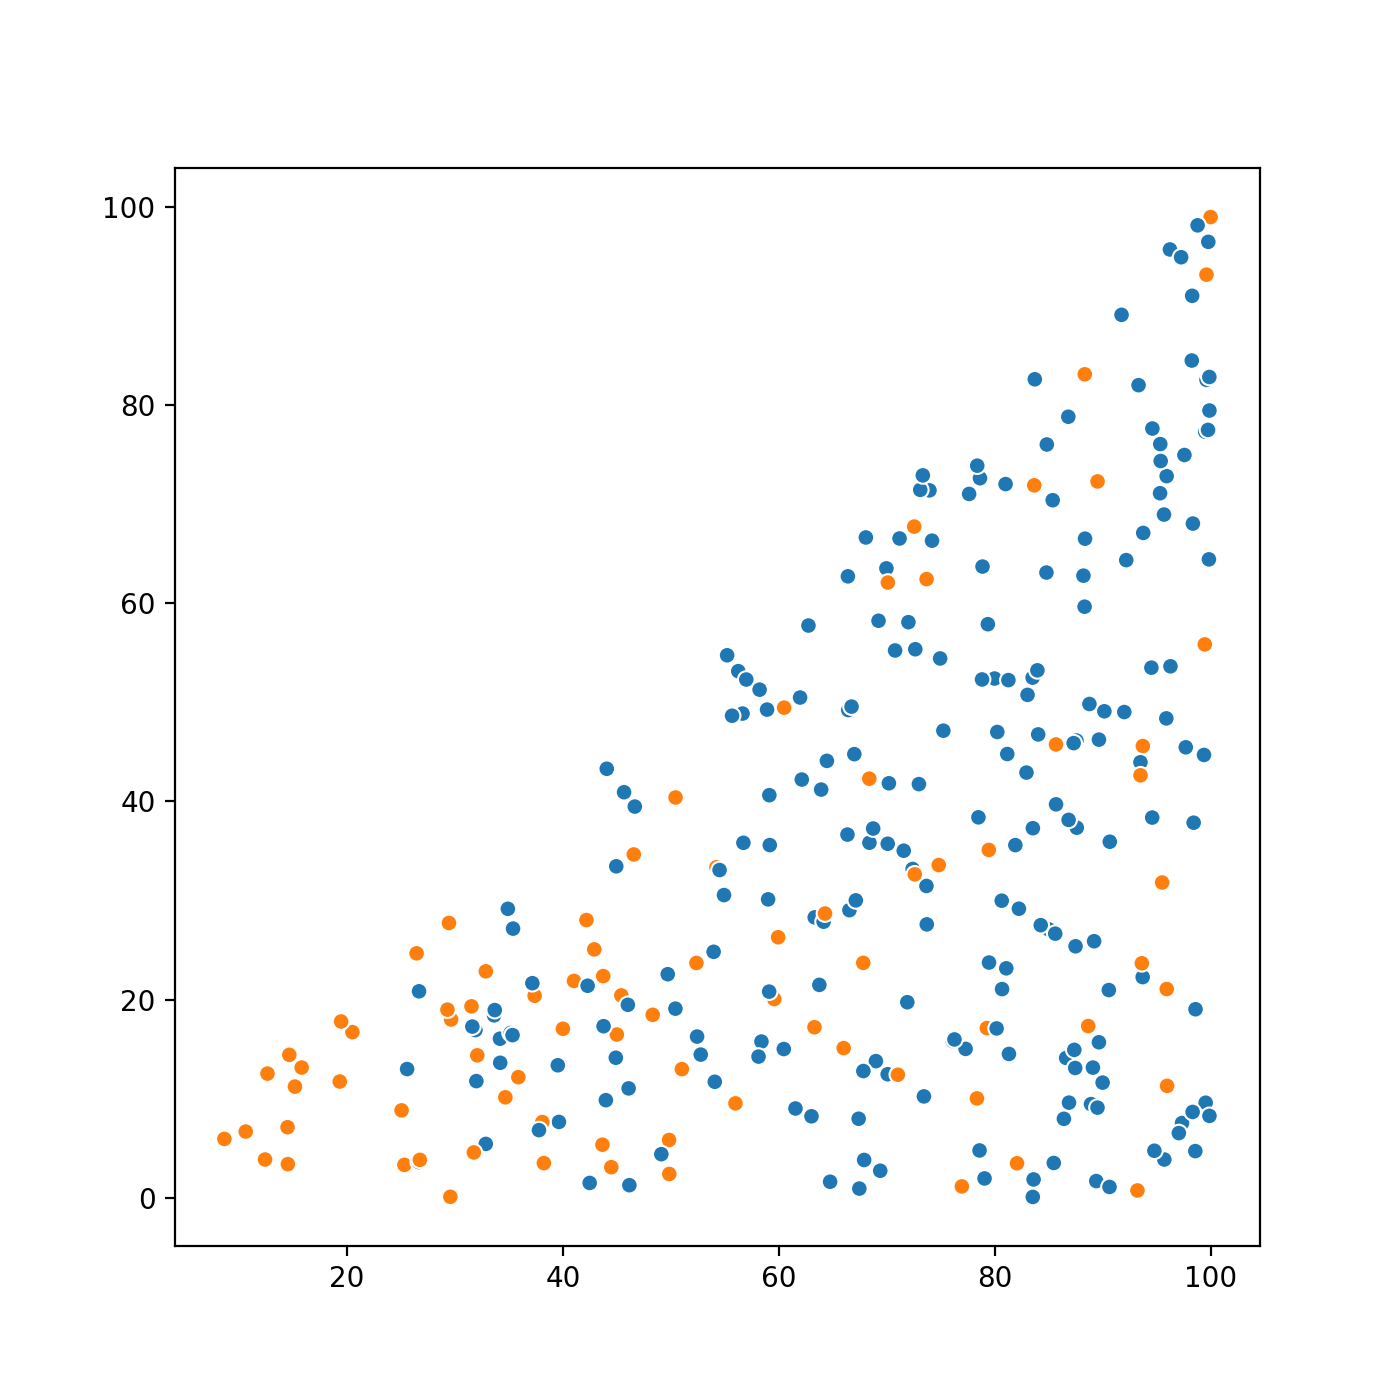

In [493]:
pa = post_analysis_multi(points1, res1)
pa.plot_cloud_point()

In [ ]:
pa.plot_prob_vs_radius()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
ro = round_off()
# setup optmizer
paras = {}
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro
paras['multi_runs'] = True
cma = cma_es()

# boil down to one expreiment
exp2 = single_experiment()
exp2.set_objective(ak)

num = 300

res2 = np.zeros((num, ))
points2 = sample_from_square([100,100], [50,50], num)

for i in range(num):
    paras['mean0'] = points[i,:].reshape(2,1)
    cma.set_parameters(paras)
    exp2.set_optimise(cma)
    status = exp2.do()
    if(status == 'global minimum'):
        res2[i] = 1
    else:
        res2[i] = 0

In [ ]:
pa2 = post_analysis_multi(points2, res2)
pa2.plot_cloud_point()

In [ ]:
pa2 = post_analysis_multi(points, res)
pa2.plot_prob_vs_radius()

In [ ]:
class single_experiment:
    def set_objective(self, objective_func):
        self.objective_func = objective_func

    def set_optimise(self, optimizer):
        self.optimizer = optimizer

    def do(self):
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
            print("dist_val", np.linalg.norm(optimum - self.objective_func.get_optimum()))
        print(statistics['status'])
        if self.optimizer.record == True:
            return statistics['status']
        else:
            self.analyser = post_analysis(statistics, self.objective_func)

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = default

cma = cma_es()
cma.set_parameters(paras)

# boil down to one expreiment
exp1 = single_experiment()
exp1.set_objective(ak)
exp1.set_optimise(cma)
exp1.do()

In [ ]:
#exp1.analyser.print_mean_variance()

In [ ]:
np.random.seed(34)
# setup objective function
ak = ackley()
# setup adjust function optimizer
line = line_search(alpha=2, beta=0.1)

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = line

cma2 = cma_es()
cma2.set_parameters(paras)

# boil down to one expreiment
exp2 = single_experiment()
exp2.set_objective(ak)
exp2.set_optimise(cma2)
exp2.do()

In [ ]:
exp2.analyser.plot_distance()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
ro = round_off()

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro

cma3 = cma_es()
cma3.set_parameters(paras)

# boil down to one expreiment
exp3 = single_experiment()
exp3.set_objective(ak)
exp3.set_optimise(cma3)
exp3.do()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
l1 = line_search_1step(alpha=1, beta=0.1)

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = l1

cma4 = cma_es()
cma4.set_parameters(paras)

# boil down to one expreiment
exp4 = single_experiment()
exp4.set_objective(ak)
exp4.set_optimise(cma4)
exp4.do()

In [ ]:
exp1.analyser.print_points_before_and_after_adjust()

In [ ]:
exp1.analyser.print_evaluations_per_iteration()

In [ ]:
exp1.analyser.print_mean_variance()

In [ ]:
exp1.analyser.plot_distance()

In [ ]:
ana = post_analysis(statistics, ak)

In [ ]:
ana.plot_distance()

In [ ]:
ana.animate_moving_cluster()

In [ ]:
ana.animate_scatterplot_distance()

In [ ]:
ana.plot_moving_cluster()